In [11]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
from BlockDefinitions import *
from Functions import *

In [13]:
from scipy.stats import unitary_group
import math
import numpy as np
import itertools

# Random states generation

In [14]:
dev = qml.device('default.qubit', wires = 2)

In [18]:
def rand_state(thetas, phis, wires):
    qml.RY(thetas[0],wires[0])
    qml.PhaseShift(phis[0],wires[0])

    qml.CRY(thetas[1], wires)
    qml.CPhase(phis[2]-phis[0]-np.pi, wires)

    qml.CRY(thetas[2], wires[::-1])
    qml.CPhase(phis[1]-phis[2]+np.pi, wires[::-1])

    qml.CNOT(wires[::-1])

(<Figure size 1000x300 with 1 Axes>, <Axes:>)

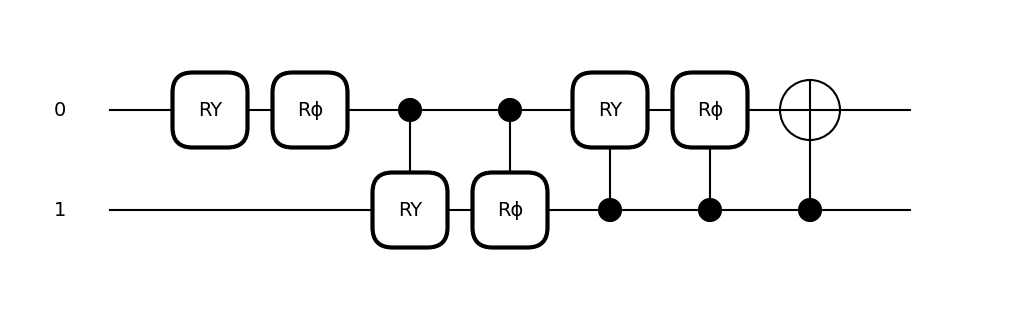

In [19]:
qml.draw_mpl(rand_state)([0,0,0],[0,0,0],[0,1])

In [20]:
@qml.qnode(dev)
def rand_state_circ(thetas, phis, wires):
    rand_state(thetas, phis, wires)
    return qml.state()

In [21]:
def P(theta,k):
    return k*np.sin(theta)*np.sin(theta/2)**(2*k-2)

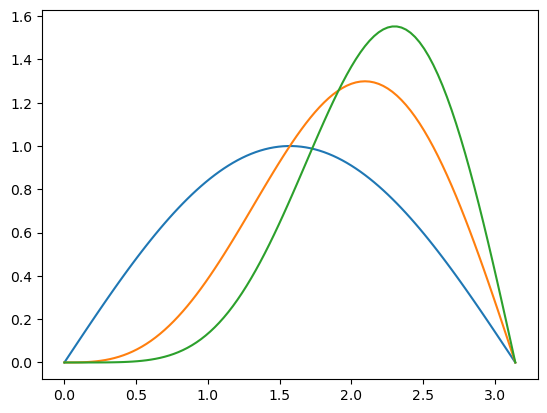

In [22]:
theta = np.linspace(0,np.pi,100)
plt.plot(theta, P(theta, 1))
plt.plot(theta, P(theta, 2))
plt.plot(theta, P(theta, 3))

In [23]:
def transform(x,k):
    return 2*np.arcsin(x**(1/(2*k)))

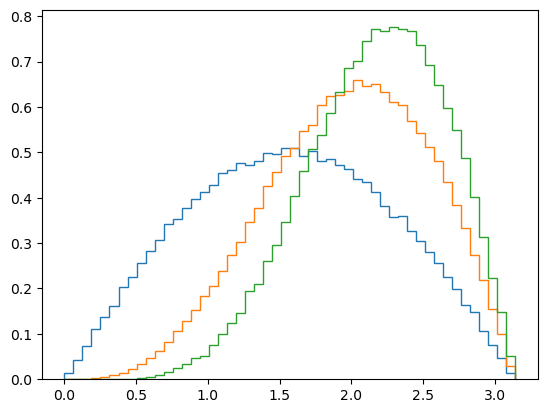

In [24]:
plt.hist(transform(np.random.rand(100000),1), bins=50, range=[0,np.pi], density=True, histtype='step');
plt.hist(transform(np.random.rand(100000),2), bins=50, range=[0,np.pi], density=True, histtype='step');
plt.hist(transform(np.random.rand(100000),3), bins=50, range=[0,np.pi], density=True, histtype='step');

# Bulk-boundary map

In [27]:
n_wires = 9
dev = qml.device('default.qubit', wires = n_wires)

@qml.qnode(dev)
def circ(thetas, phis):
    rand_state(thetas, phis, wires=[0,1])
    circAA(wires=[0,2,3,4,5])
    circBB(wires=[1,2,6,7,8])
    qml.measure(0, postselect=0)
    qml.measure(1, postselect=0)
    qml.measure(2, postselect=0)
    return qml.mutual_info(wires0=[3,4,5], wires1=[6,7,8], log_base=2)

In [29]:
boundary_mis = []
for _ in range(10000):
    thetas = np.array([transform(np.random.rand(1),1), transform(np.random.rand(1),2), transform(np.random.rand(1),3)]).flatten()
    phis = np.random.rand(3)*np.pi*2
    boundary_mi = circ(thetas, phis)
    boundary_mis.append(boundary_mi)

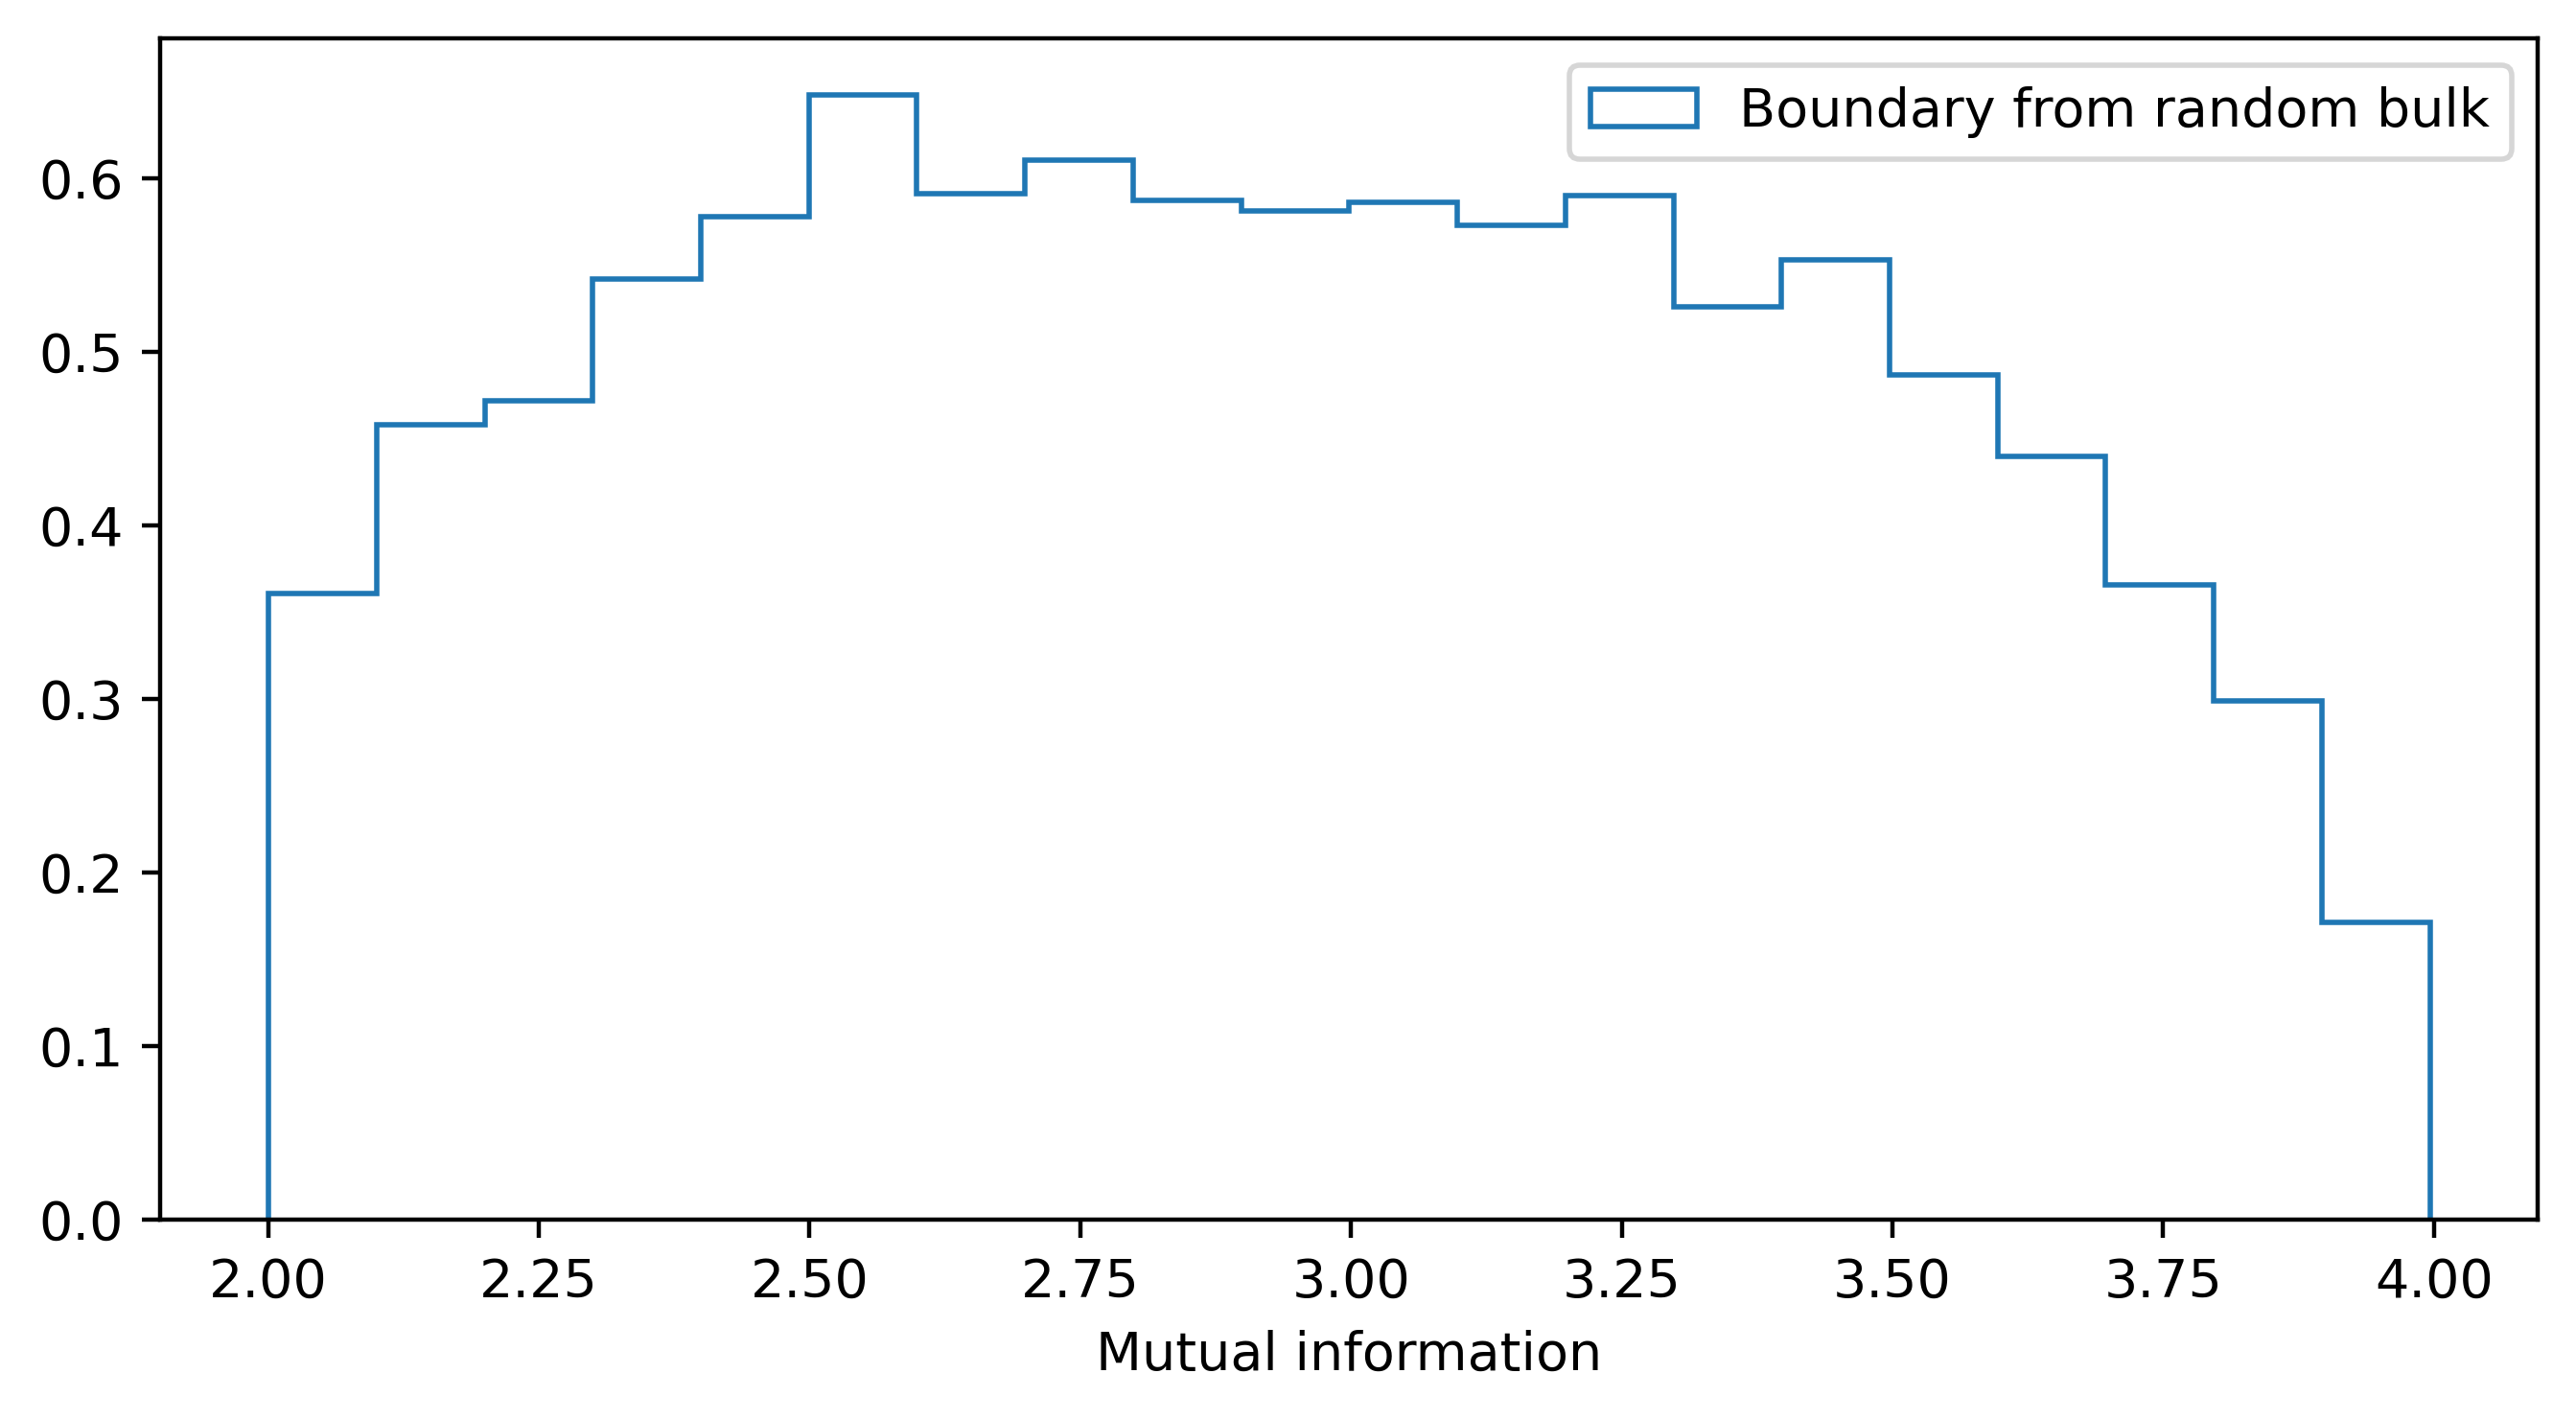

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
fig.set_dpi(400)

ax.hist(boundary_mis, bins=20, histtype='step', density=True, label='Boundary from random bulk');
ax.set_xlabel('Mutual information')
ax.legend()

fig.savefig('boundary_hist.png')

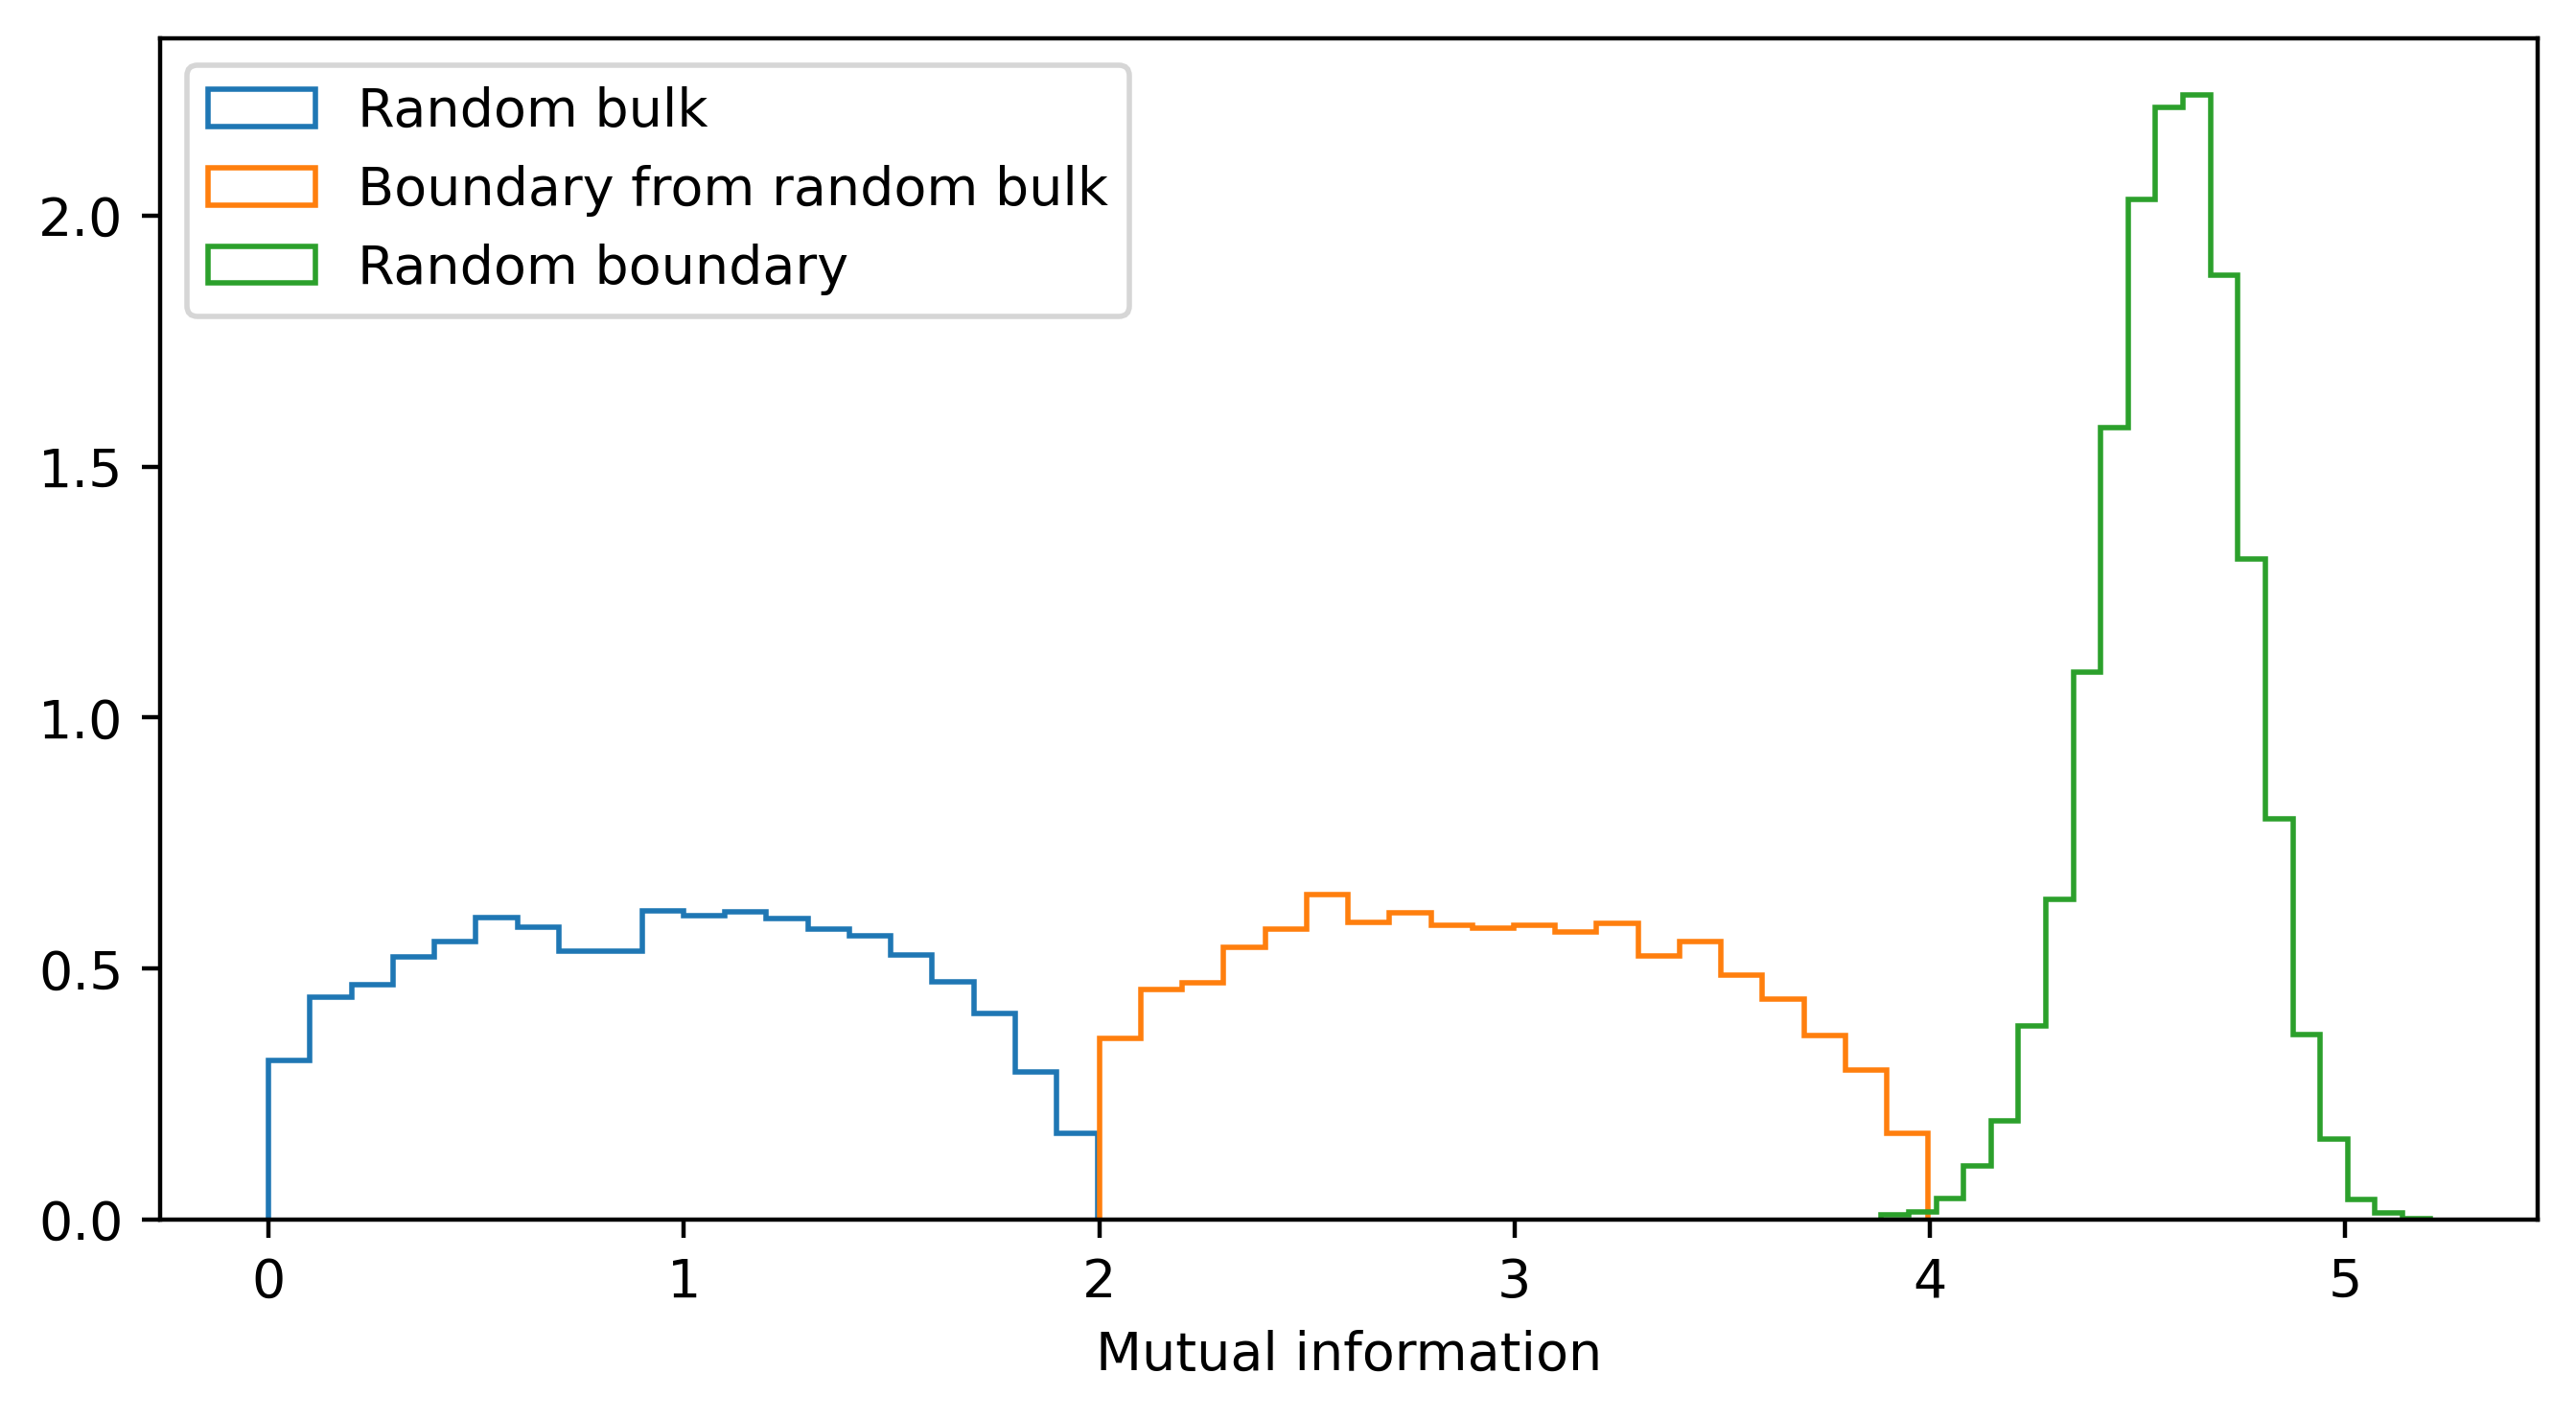

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
fig.set_dpi(400)

ax.hist(bulk_mis2, bins=20, histtype='step', density=True, label='Random bulk');
ax.hist(boundary_mis, bins=20, histtype='step', density=True, label='Boundary from random bulk');
ax.hist(boundary_rand_mis, bins=20, histtype='step', density=True, label='Random boundary');
ax.set_xlabel('Mutual information')
ax.legend()

fig.savefig('boundary_bulk_hist.png')